**KAGGLE COMPETITION : DEEP LEARNING APPROACH**

**A. Preprocessing**
1. Import libraries
2. Import dataset
3. Basic data cleaning : get rid of null values, punctuation and html tags
4. NLP data preprocessing : remove stop words, stem/lemmatize words
5. Word embeddings
<!-- 5. Test-Train split
6. Vecorize data (fit on the train data and use on train+test data) with countvec or tfidfvec
7. Oversample data (deal with imbalanced data with SMOTE) -->

**B. Models**

Implement DL models (RNN,LSTM,BERT...)

**C. Make prediction** 

Submit predictions and put my name on the leaderboard !!

In [25]:
import pandas as pd
import numpy as np
import regex as re
import os
import pickle
import scipy
import nltk
from imblearn.over_sampling import SMOTE
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #, ENGLISH_STOP_WORDS

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adrie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adrie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# Fix contractions ???
# import contractions
# text = [contractions.fix(word) for word in text]

# Only keep English words ? (too computationally heavy ?, worth it since we only take the most common words ?)
# nltk.download('words')
# from nltk.corpus import words
# "would" in words.words()

# Horrible Accident Man Died In Wings Of ÛÏAirplaneÛ 29-07-2015. WTF You CanÛªt Believe Your EYES ÛÒ... http://t.co/6fFyLAjWpS
# Aftershock ã¢ (2010) Fullã¢ Streaming - YouTube http://t.co/vVE3UsesGf

def clean_reviews(review):
    #get rid of all main abbreviations and urls (and replace them with "http") + find and replace all punctuation with "" and all html tags with " " + lower
    bad_lingo = ["rt", "û_", "amp", "ûª", "ûªs", "ûò", "ûï", "ûó", "åè", "ìñ1", "\x89", "...", "..", "via"]
    review = " ".join([re.sub('http.*','http',word) for word in review.split() if word not in bad_lingo]) 
    REPLACE_NO_SPACE = re.compile("[.;:*#@!ã¢ÛÏ=><\'?,\"()\[\]]")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    review = REPLACE_NO_SPACE.sub("", review.lower()) 
    review = REPLACE_WITH_SPACE.sub(" ", review)
    return review

def remove_repeating_words(review):
    #review1 = ' '.join(set(review.split()))
    review = ' '.join(dict.fromkeys(review.split()))
    return review

def remove_stop_words(review):
    #stop_words_list = ENGLISH_STOP_WORDS #stop_words.
    stop_words_list = set(stopwords.words('english'))
    review = " ".join(word for word in review.split(" ") if word not in stop_words_list)
    return review

def stem_reviews(review):
    # PB : NEED TO INITIATE A NEW STEMMER FOR EACH ROW...
    stemmer = PorterStemmer()
    #separator.join(list of strings) => 1 long string
    #string.split(separator) => list of strings
    review = " ".join([stemmer.stem(word) for word in review.split(" ")])
    return review

def lemmatize_reviews(review):
    lemmatizer = WordNetLemmatizer()
    #separator.join(list of strings) => 1 long string
    #string.split(separator) => list of strings
    review = " ".join([lemmatizer.lemmatize(word) for word in review.split(" ")])
    return review

def oversample(data_list):
    [X_train, y_train, X_eval, y_eval] = data_list
    sm = SMOTE()
    X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)
    X_eval_sm, y_eval_sm = sm.fit_resample(X_eval,y_eval)
    assert len(y_train_sm.value_counts().unique())==1 and len(y_eval_sm.value_counts().unique())==1
    return [X_train_sm, y_train_sm,X_eval_sm, y_eval_sm]

# Add tokenization ?
# twt = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
# a = twt.tokenize(a)


In [30]:
def read_input_data(filename, separator, use_cols, header, col_dict):
    print("Reading input data")
    df = pd.read_csv(filename, sep = separator, usecols = use_cols, header = header)
    df.rename(columns = col_dict, inplace = True)
    print(df.shape)
    print(df.head())
    return df

def basic_clean(df) -> None:
    print("Basic Data Preprocessing : \n Dropping null values \n Getting rid of punctuation and HTML tags + text in lowercase \n Removing repeating words")
    df.dropna(inplace = True)
    df["Reviews"] = df["Reviews"].apply(lambda row : remove_repeating_words(clean_reviews(row)))


def nlp_clean(df, nlp_method) -> None:
    print("NLP Data Preprocessing : Removing stop words \n Stemming/Lemmatizing reviews")
    if nlp_method == "stem":
        df["Reviews"] = df["Reviews"].apply(lambda row : stem_reviews(remove_stop_words(row)))
    elif nlp_method == "lemmatize":
        df["Reviews"] = df["Reviews"].apply(lambda row : lemmatize_reviews(remove_stop_words(row)))
    else:
        df["Reviews"] = df["Reviews"].apply(lambda row : remove_stop_words(row))


# there seem to be some issues with the data list...
def data_split(X, y, test_size = 0.2, random_state = 42) -> None:
    y_ohe = pd.get_dummies(y)
    print(y_ohe)
    data_list = train_test_split(X,y_ohe,test_size=test_size,random_state=random_state)
    return data_list

In [31]:
# print("**************** PREPROCESSING TRAIN DATA ****************")
# train_vec, train_data_list = data_preprocessor_train("train.tsv", '\t', 0, [2, 3], {"Phrase":"Reviews","Sentiment":"Sentiments"})
# print("**************** PREPROCESSING TEST DATA ****************")
# test_vec, test_data = data_processor_test("test.tsv", '\t', 0, [0, 2], [0],{"Phrase":"Reviews"}, train_vec) #NO NEED FOR THE PHRASEID COLUMN (INDEX IS NOT NECESSARY)

df = read_input_data("data/train.csv", ',', [3,4],0,{"text":"Reviews","target":"Sentiments"})
basic_clean(df)
nlp_clean(df,"lemmatize")
df.to_csv("nlp_clean_df.csv",index=False)
print(df.head())

Reading input data
(7613, 2)
                                             Reviews  Sentiments
0  Our Deeds are the Reason of this #earthquake M...           1
1             Forest fire near La Ronge Sask. Canada           1
2  All residents asked to 'shelter in place' are ...           1
3  13,000 people receive #wildfires evacuation or...           1
4  Just got sent this photo from Ruby #Alaska as ...           1
Basic Data Preprocessing : 
 Dropping null values 
 Getting rid of punctuation and HTML tags + text in lowercase 
 Removing repeating words
NLP Data Preprocessing : Removing stop words 
 Stemming/Lemmatizing reviews
                                             Reviews  Sentiments
0         deed reason earthquake may allah forgive u           1
1              forest fire near la ronge sask canada           1
2  resident asked shelter place notified officer ...           1
3  13000 people receive wildfire evacuation order...           1
4  got sent photo ruby alaska smoke wild

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

MAX_WORDS = 2500
MAX_LEN = 200

def tokenize_data(df, tk = None, max_words = MAX_WORDS, max_len = MAX_LEN):
    data = df['Reviews'].values.tolist()
    print(data[:10])
    if tk == None:
        tokenizer = Tokenizer(num_words=max_words)
        tokenizer.fit_on_texts(data)
    else:
        tokenizer = tk
    sequences_init = tokenizer.texts_to_sequences(data)
    sequences = pad_sequences(sequences_init, maxlen=max_len)
    print(f"Size of input tokenized data :\n(Nb of samples, sequence length) = {sequences.shape}")
    # print(sequences)
    return sequences, tokenizer



Using TensorFlow backend.


In [14]:
sequences, tokenizer = tokenize_data(df)
data_list = data_split(sequences, df["Sentiments"])
data_list


['deed reason earthquake may allah forgive u', 'forest fire near la ronge sask canada', 'resident asked shelter place notified officer evacuation order expected', '13000 people receive wildfire evacuation order california', 'got sent photo ruby alaska smoke wildfire pours school', 'rockyfire update california hwy 20 closed direction due lake county fire cafire wildfire', 'flood disaster heavy rain cause flash flooding street manitou colorado spring area', 'im top hill see fire wood', 'there emergency evacuation happening building across street', 'im afraid tornado coming area']
Size of input tokenized data :
(Nb of samples, sequence length) = (7613, 200)
      0  1
0     0  1
1     0  1
2     0  1
3     0  1
4     0  1
...  .. ..
7608  0  1
7609  0  1
7610  0  1
7611  0  1
7612  0  1

[7613 rows x 2 columns]


[array([[   0,    0,    0, ...,  174,    1,    2],
        [   0,    0,    0, ..., 2250,  368,  141],
        [   0,    0,    0, ...,   46,    1,    2],
        ...,
        [   0,    0,    0, ...,  949,    1,    2],
        [   0,    0,    0, ...,  470,    1,    2],
        [   0,    0,    0, ...,   18,    1,    2]]),
 array([[   0,    0,    0, ...,  126, 1270,  285],
        [   0,    0,    0, ...,  326,   53, 1590],
        [   0,    0,    0, ..., 1706,    1,    2],
        ...,
        [   0,    0,    0, ...,    1,    2,   10],
        [   0,    0,    0, ...,  184,    1,    2],
        [   0,    0,    0, ...,  343,    1,    2]]),
       0  1
 4996  0  1
 3263  1  0
 4907  0  1
 2855  0  1
 4716  1  0
 ...  .. ..
 5226  1  0
 5390  1  0
 860   1  0
 7603  0  1
 7270  0  1
 
 [6090 rows x 2 columns],
       0  1
 2644  0  1
 2227  1  0
 5448  0  1
 132   1  0
 6845  1  0
 ...  .. ..
 1835  1  0
 506   0  1
 3592  0  1
 6740  0  1
 1634  1  0
 
 [1523 rows x 2 columns]]

In [15]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint


def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def simple_model(data_list, type):
    model_name = f"simple_model_{type}"
    X_train, X_test, y_train, y_test = data_list
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    model1 = Sequential()
    model1.add(layers.Embedding(MAX_WORDS, 20, input_length=MAX_LEN)) #The embedding layer
    if type == "lstm":
        model1.add(layers.LSTM(15,dropout=0.5)) #Our LSTM layer with dropout (regularization)
    else:
    # Possibility to add multiple RNN layers instead of a single LSTM layer
    # NEED TO RETURN ALL SEQUENCES !!!
        model1.add(layers.SimpleRNN(15, return_sequences=True))
        model1.add(layers.SimpleRNN(15, dropout=0.5))
    model1.add(layers.Dense(2,activation='sigmoid')) #Activation function for binary classifiation
    # OUTPUT VECTORS MUST BE ONE HOT ENCODED !!!!!!!!!!!!!
    print(model1.summary())

    model1.compile(optimizer='adam',loss='binary_crossentropy', metrics=[get_f1]) #other optimizer : rmsprop, adadelta

    model_file_name = f"best_{model_name}.hdf5"
    checkpoint1 = ModelCheckpoint(model_file_name, monitor='val_get_f1', verbose=5,save_best_only=True, mode='max', period=1,save_weights_only=False)
    history = model1.fit(X_train, y_train, epochs=20,batch_size=128,validation_data=(X_test, y_test),callbacks=[checkpoint1])
    return history, model_name

def bid_model(data_list):
    model_name = "bid_model"
    X_train, X_test, y_train, y_test = data_list
    model2 = Sequential()
    model2.add(layers.Embedding(MAX_WORDS, 40, input_length=MAX_LEN))
    model2.add(layers.Bidirectional(layers.LSTM(128,dropout=0.2))) #0.2
    model2.add(layers.Dense(64, activation = 'relu'))
    model2.add(layers.Dropout(0.5))
    model2.add(layers.Dense(2,activation='sigmoid'))
    print(model2.summary())
    model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=[get_f1]) 
    model_file_name = f"best_{model_name}.hdf5"
    checkpoint2 = ModelCheckpoint(model_file_name, monitor='val_get_f1', verbose=5,save_best_only=True, mode='max', period=1,save_weights_only=False)
    history = model2.fit(X_train, y_train, epochs=10,batch_size=128, validation_data=(X_test, y_test),callbacks=[checkpoint2])
    return history, model_name

def conv1D_model(data_list):
    model_name = "conv1D_model"
    X_train, X_test, y_train, y_test = data_list
    model3 = Sequential()
    model3.add(layers.Embedding(MAX_WORDS, 40, input_length=MAX_LEN))
    model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
    model3.add(layers.MaxPooling1D(5))
    model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
    model3.add(layers.GlobalMaxPooling1D())
    model3.add(layers.Dense(2,activation='sigmoid'))
    print(model3.summary())
    model3.compile(optimizer='adam',loss='binary_crossentropy',metrics=[get_f1])
    model_file_name = f"best_{model_name}.hdf5"
    checkpoint3 = ModelCheckpoint(model_file_name, monitor='val_get_f1', verbose=5,save_best_only=True, mode='max', period=1,save_weights_only=False)
    history = model3.fit(X_train, y_train, epochs=20,batch_size=128,validation_data=(X_test, y_test), callbacks=[checkpoint3])
    return history, model_name


In [16]:
from time import time
t0 = time()
# history, model_name = simple_model(data_list, "lstm")
history, model_name = bid_model(data_list)
# history, model_name = conv1D_model(data_list)
train_time = time() - t0
print(train_time)
print(history.history)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 40)           100000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               173056    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 289,634
Trainable params: 289,634
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\adrie\anaconda3\envs\sentiment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 61s 10ms/step - loss: 0.6524 - get_f1: 0.6066 - val_loss: 0.5594 - val_get_f1: 0.7603

Epoch 00001: val_get_f1 improved from -inf to 0.76033, saving model to best_bid_model.hdf5
Epoch 2/10
6090/6090 [==============================] - 68s 11ms/step - loss: 0.4467 - get_f1: 0.8133 - val_loss: 0.4284 - val_get_f1: 0.8066

Epoch 00002: val_get_f1 improved from 0.76033 to 0.80660, saving model to best_bid_model.hdf5
Epoch 3/10
6090/6090 [==============================] - 34s 6ms/step - loss: 0.3514 - get_f1: 0.8599 - val_loss: 0.4443 - val_get_f1: 0.7932

Epoch 00003: val_get_f1 did not improve from 0.80660
Epoch 4/10
6090/6090 [==============================] - 35s 6ms/step - loss: 0.3063 - get_f1: 0.8821 - val_loss: 0.4893 - val_get_f1: 0.7849

Epoch 00004: val_get_f1 did not improve from 0.80660
Epoch 5/10
6090/6090 [==============================] - 35s 6ms/step - loss: 0.2822 - get_f

{'val_loss': [0.5594435150656196, 0.4283680258342019, 0.4443086137211174, 0.48931304256303954, 0.4976419954024407, 0.5489914063865702, 0.5775257508690547, 0.6116051645710996, 0.6565123712711246, 0.7026530731608815], 'val_get_f1': [0.7603314518928528, 0.8065962791442871, 0.7932372689247131, 0.7849013805389404, 0.7915590405464172, 0.7767944931983948, 0.7708186507225037, 0.7726423144340515, 0.7644334435462952, 0.766598641872406], 'loss': [0.6523705070437664, 0.4466522508066863, 0.35143632870198077, 0.30631173562338004, 0.2821619337806952, 0.26265380840583386, 0.23957492447838993, 0.23127264639818415, 0.21694227341067027, 0.20282373769921427], 'get_f1': [0.60658085, 0.81331915, 0.8599108, 0.88214874, 0.8935738, 0.9003834, 0.91306263, 0.9140621, 0.9200549, 0.92371315]}


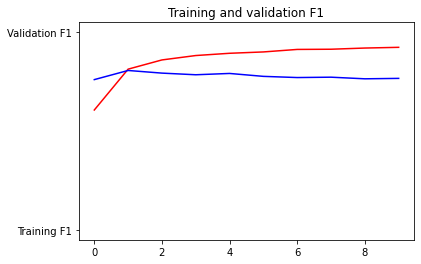

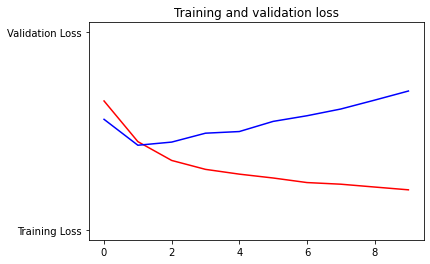

<Figure size 432x288 with 0 Axes>

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(f1))
plt.plot(epochs, f1, 'r', 'Training F1')
plt.plot(epochs, val_f1, 'b', 'Validation F1')
plt.title('Training and validation F1')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()
print(history.history)

In [18]:
from keras import models

df_test = read_input_data("data/test.csv", ',', [3],0,{"text":"Reviews"})
basic_clean(df_test)
nlp_clean(df_test,"lemmatize")
X_pred, _ = tokenize_data(df_test, tk = tokenizer)
print(X_pred)

dependencies = {
    'get_f1': get_f1
}
model_file_name = f"best_{model_name}.hdf5"
final_model = models.load_model(model_file_name, custom_objects=dependencies)
final_pred = final_model.predict_classes(X_pred)
# index = pd.read_csv("test.tsv", sep = '\t').index

submission = pd.read_csv("data/test.csv",usecols=[0])
submission["target"] = final_pred  #pd.DataFrame({"id":[i for i in range(156061,222353)],"target":y_pred})
submission.to_csv(f"Submission_{model_name}.csv", index=False)

Reading input data
(3263, 1)
                                             Reviews
0                 Just happened a terrible car crash
1  Heard about #earthquake is different cities, s...
2  there is a forest fire at spot pond, geese are...
3           Apocalypse lighting. #Spokane #wildfires
4      Typhoon Soudelor kills 28 in China and Taiwan
Basic Data Preprocessing : 
 Dropping null values 
 Getting rid of punctuation and HTML tags + text in lowercase 
 Removing repeating words
NLP Data Preprocessing : Removing stop words 
 Stemming/Lemmatizing reviews
['happened terrible car crash', 'heard earthquake different city stay safe everyone', 'forest fire spot pond goose fleeing across street cannot save', 'apocalypse lighting spokane wildfire', 'typhoon soudelor kill 28 china taiwan', 'shakingits earthquake', 'theyd probably still show life arsenal yesterday eh', 'hey', 'nice hat', 'fuck']
Size of input tokenized data :
(Nb of samples, sequence length) = (3263, 200)
[[   0    0    0 ...

C:\Users\adrie\anaconda3\envs\sentiment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
